In [1]:
import numpy as np
from scipy.stats import norm
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")

import networkx as nx

def unzip(l):
    return list(zip(*l))

# Make gaussian subsets to use for sampling

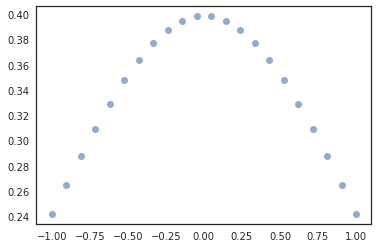

In [2]:
fig, ax = plt.subplots(1, 1)

rv = norm(loc=0, scale=1)
points = 11
x = np.linspace(-1, 1, points * 2)
ax.plot(x, list(rv.pdf(x)), "o", lw=5, alpha=0.6, label="norm pdf")

In [3]:
def normal_subsets(side_len, scale):
    rv = norm(loc=0, scale=scale)
    x = np.linspace(-1, 1, side_len * 2 + 1)
    p = rv.pdf(x)
    peak = side_len
    cols = list(range(side_len))
    subsets = []
    for col in cols:
        start = peak - col
        stop = start + side_len
        subset = np.array(p[start:stop])
        subset /= subset.sum()
        subsets.append(subset)
    for subset in subsets:
        assert np.isclose(subset.sum(), 1.0)
    return subsets

In [4]:
subsets = normal_subsets(50, 1)

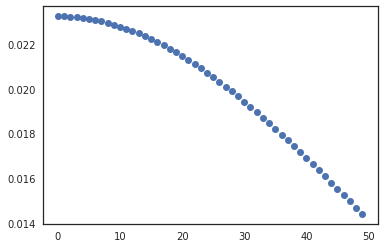

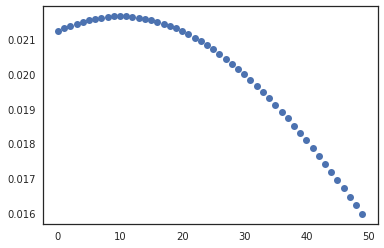

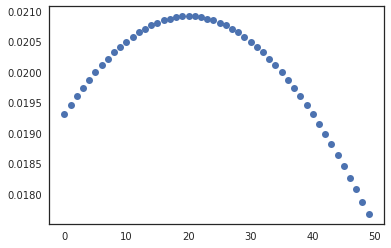

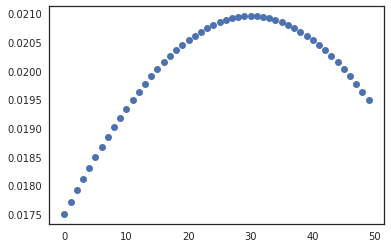

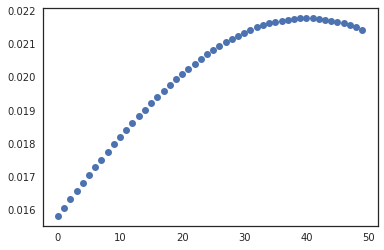

In [5]:
for subset in subsets[::10]:
    plt.plot(subset, "o")
    plt.show()

# Lattice layout to use with networkx

In [6]:
def make_layout(side_len):
    points = side_len ** 2
    x, y = np.meshgrid(np.arange(side_len), np.arange(side_len))  # make grid
    x, y = x.reshape(points), y.reshape(points)  # flatten to turn into pairs
    layout = {
        (points - 1 - idx): coords for idx, coords in enumerate(zip(reversed(x), y))
    }  # assign x,y to each node idx
    # points -1 and reverserd are used to match row/cols matrix format
    return layout

In [7]:
g = nx.Graph()
g.add_nodes_from(list(range(25)))

In [8]:
pos = make_layout(5)
pos

{24: (4, 0),
 23: (3, 0),
 22: (2, 0),
 21: (1, 0),
 20: (0, 0),
 19: (4, 1),
 18: (3, 1),
 17: (2, 1),
 16: (1, 1),
 15: (0, 1),
 14: (4, 2),
 13: (3, 2),
 12: (2, 2),
 11: (1, 2),
 10: (0, 2),
 9: (4, 3),
 8: (3, 3),
 7: (2, 3),
 6: (1, 3),
 5: (0, 3),
 4: (4, 4),
 3: (3, 4),
 2: (2, 4),
 1: (1, 4),
 0: (0, 4)}

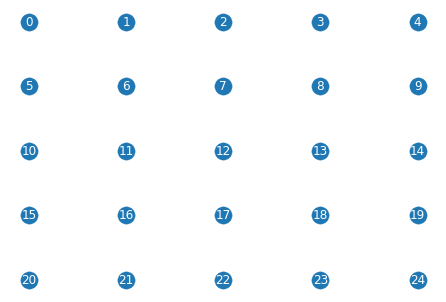

In [9]:
nx.draw(g, with_labels=True, pos=pos,font_color="white")

# Edge sampling strategies

In [10]:
# local uses the precomputed gaussian SUBSETS to connect to neighbours
def local_sample(
    node, samples, side_len
):  # boi this is a mindfuck, refer to the picture above
    col = node % side_len  # e.g. 11 % 5 -> col 1
    row = node // side_len  # e.g. 11 // 5 -> row 2
    points = np.arange(side_len)
    to_row = np.random.choice(points, p=subsets[row], size=samples)
    to_col = np.random.choice(points, p=subsets[col], size=samples)
    # reconstruct the node idx from rows and cols
    return [(node, to) for to in side_len * to_row + to_col if node != to]

# connect with everything at random
def random_sample(node, samples, num_points):
    points = np.hstack([np.arange(node), np.arange(node + 1, num_points)])
    edges = np.random.choice(points, size=samples)
    return [(node, to) for to in edges]

# mix of the previous two controlled by p -> fraction of local connections
def hybrid_sample(node, p, samples, side_len, num_points):
    assert 0 <= p and p <= 1
    _local = int(p * samples)
    _global = samples - _local
    # global
    global_points = np.hstack([np.arange(node), np.arange(node + 1, num_points)])
    global_edges = np.random.choice(global_points, size=_global)
    global_edges = [(node, to) for to in global_edges]
    # local
    col = node % side_len  # e.g. 11 % 5 -> col 1
    row = node // side_len  # e.g. 11 // 5 -> row 2
    local_points = np.arange(side_len)
    to_row = np.random.choice(local_points, p=subsets[row], size=_local)
    to_col = np.random.choice(local_points, p=subsets[col], size=_local)
    # reconstruct the node idx from rows and cols
    local_edges = [(node, to) for to in side_len * to_row + to_col if node != to]
    return local_edges + global_edges

In [11]:
side_len = 30
num_points = side_len ** 2
locality = 0.2
subsets = normal_subsets(side_len, locality)
nodes = list(range(num_points))

In [16]:
edges = local_sample(72, 10, side_len)

In [17]:
for _from, _to in edges:
    assert 0 <= _to and _to < num_points, _to
edges[:3]

[(72, 280), (72, 70), (72, 138)]

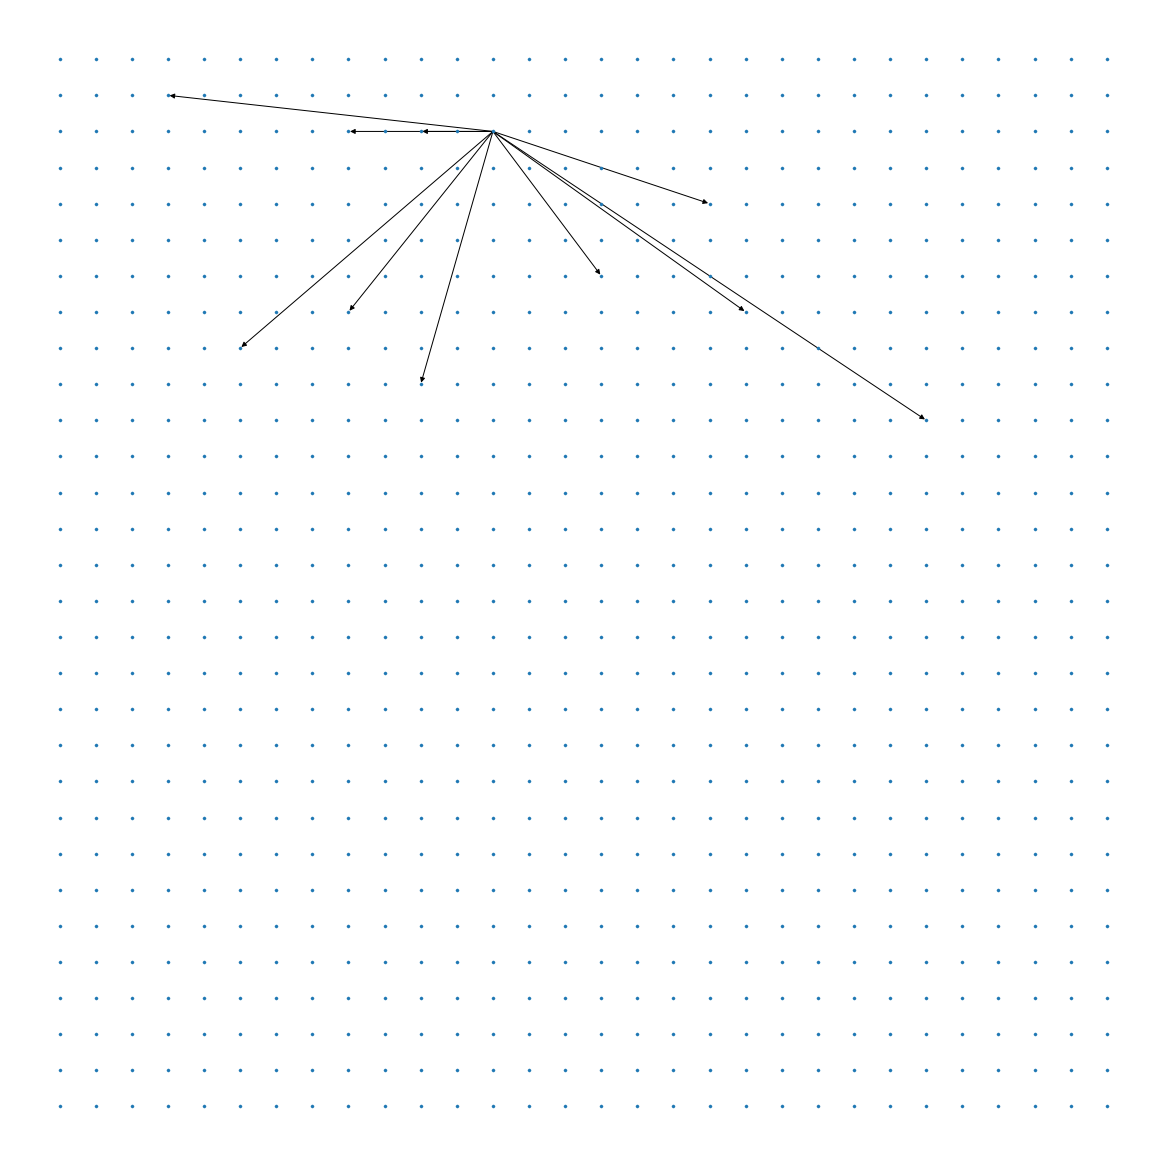

In [18]:
g = nx.DiGraph()
g.add_nodes_from(list(range(num_points)))
g.add_edges_from(edges)
pos = make_layout(side_len)
plt.figure(figsize=(16, 16))
nx.draw(g, with_labels=False, pos=pos, node_size=10)

In [28]:
side_len = 30
num_points = side_len ** 2
nodes = list(range(num_points))

In [29]:
edges = random_sample(72, 10, num_points)
for _from, _to in edges:
    assert 0 <= _to and _to < num_points, _to
edges[:3]

[(72, 110), (72, 418), (72, 821)]

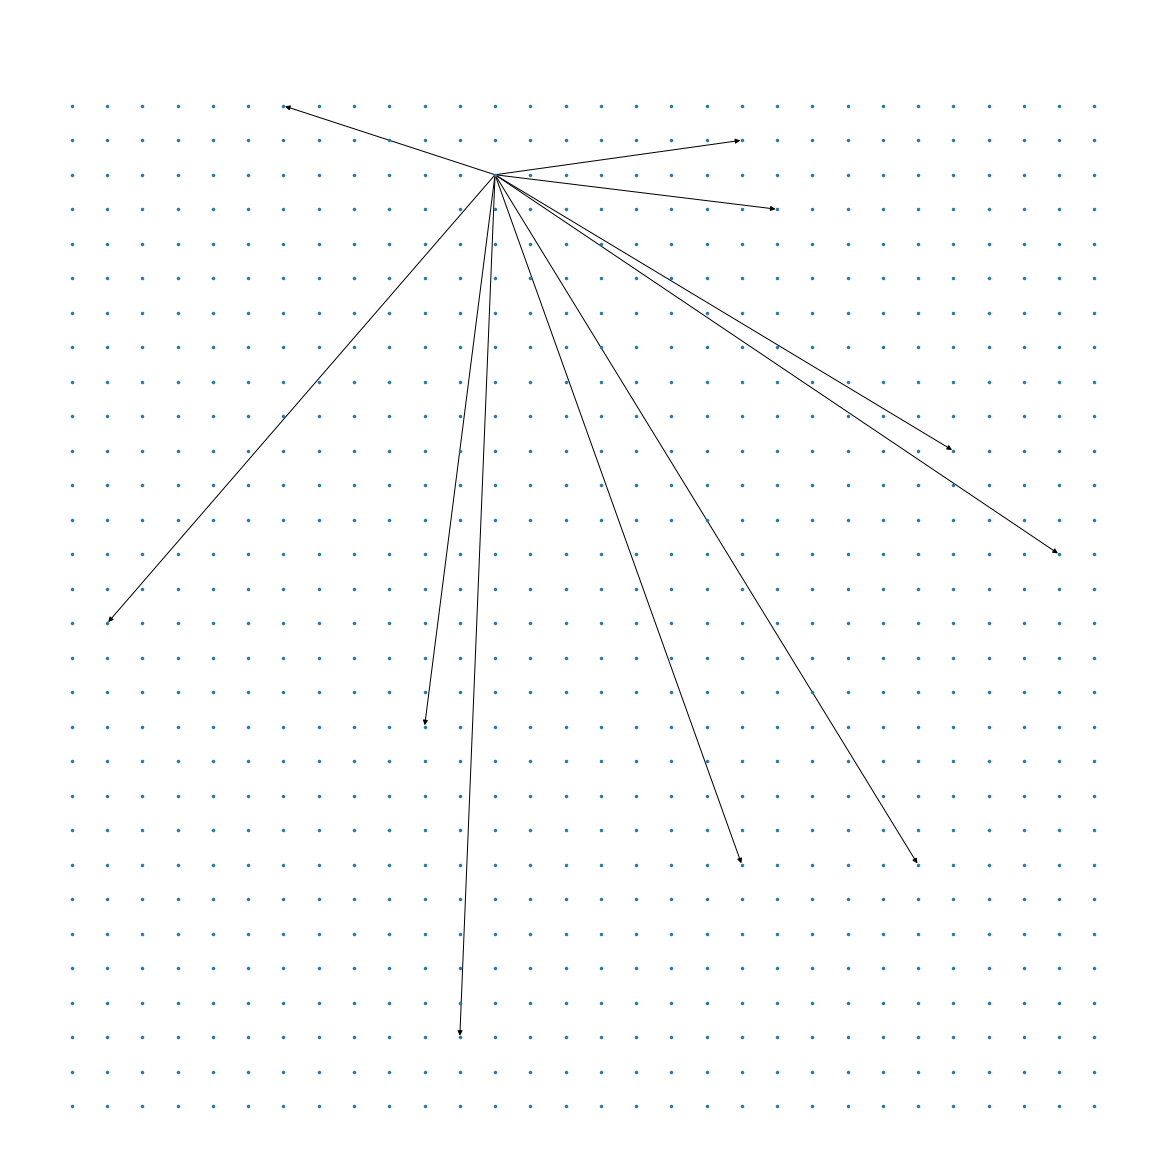

In [30]:
g = nx.DiGraph()
g.add_nodes_from(list(range(num_points)))
g.add_edges_from(edges)
pos = make_layout(side_len)
plt.figure(figsize=(16, 16))
nx.draw(g, with_labels=False, pos=pos, node_size=10)

# Visualize edge distributions

In [31]:
side_len = 50
num_points = side_len ** 2
locality = 0.2
subsets = normal_subsets(side_len, locality)
nodes = list(range(num_points))

Local gaussian from a center node, the marginal distributions (i.e. the per-axis slices are plotted on the side)

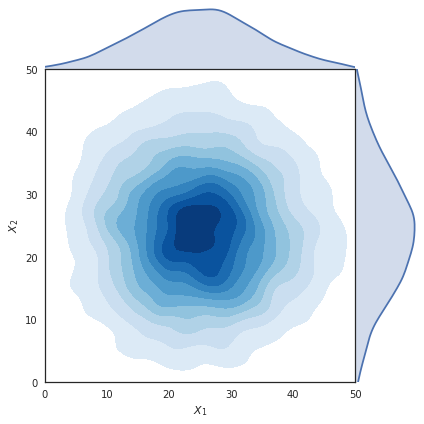

In [32]:
edges = local_sample(1225, 10000, side_len)
_, to = unzip(edges)
x1, x2 = unzip([(node % side_len, node // side_len) for node in to])
x1 = pd.Series(x1, name="$X_1$")
x2 = pd.Series(reversed(x2), name="$X_2$")

g = sns.JointGrid(x1,x2,space=0,xlim=(0, side_len), ylim=(0, side_len))
g = g.plot_joint(sns.kdeplot,cmap="Blues",shade=True, shade_lowest=False)
g = g.plot_marginals(sns.kdeplot,shade=True)

Local gaussian around a node close to an edge.

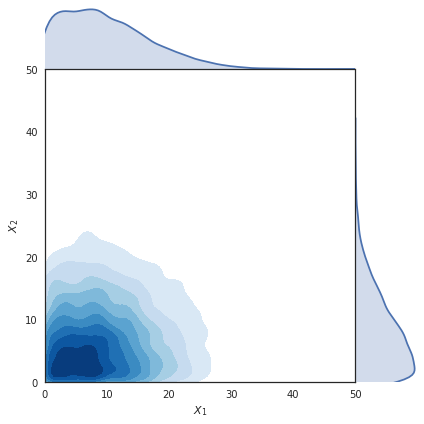

In [33]:
edges = local_sample(55, 10000, side_len)
_, to = unzip(edges)
x1, x2 = unzip([(node % side_len, node // side_len) for node in to])
x1 = pd.Series(x1, name="$X_1$")
x2 = pd.Series(reversed(x2), name="$X_2$")

# Show the joint distribution using kernel density estimation
g = sns.JointGrid(x1,x2,space=0,xlim=(0, side_len), ylim=(0, side_len))
g = g.plot_joint(sns.kdeplot,cmap="Blues",shade=True, shade_lowest=False)
g = g.plot_marginals(sns.kdeplot,shade=True)

Global uniform samples around a central node. 
Note how the marginals are almost flat (except on the edges, but that's because of the kernel used)

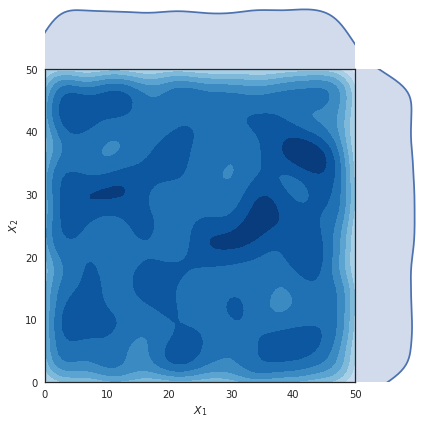

In [36]:
edges = random_sample(1225, 10000, num_points)
_, to = unzip(edges)
x1, x2 = unzip([(node % side_len, node // side_len) for node in to])
x1 = pd.Series(x1, name="$X_1$")
x2 = pd.Series(reversed(x2), name="$X_2$")

# Show the joint distribution using kernel density estimation
g = sns.JointGrid(x1,x2,space=0,xlim=(0, side_len), ylim=(0, side_len))
g = g.plot_joint(sns.kdeplot,cmap="Blues",shade=True, shade_lowest=False)
g = g.plot_marginals(sns.kdeplot,shade=True)

Hybrid samplig using a mixture of .5 gaussian, .5 uniform. Notice how the tails of the distribution are fatter because of the uniform samples. Seems biased in a cross shape because of the sampling mechanism. Bug or feature?

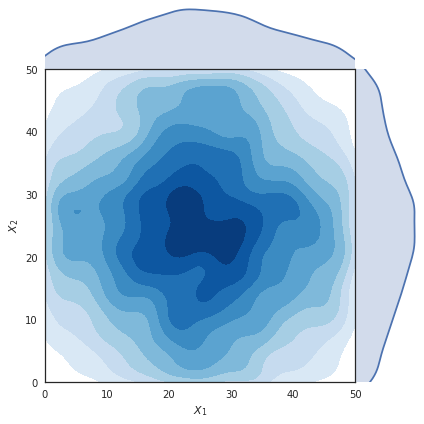

In [42]:
edges = hybrid_sample(
    node=1225, p=0.5, samples=10000, side_len=side_len, num_points=num_points
)
_, to = unzip(edges)
x1, x2 = unzip([(node % side_len, node // side_len) for node in to])
x1 = pd.Series(x1, name="$X_1$")
x2 = pd.Series(reversed(x2), name="$X_2$")

# Show the joint distribution using kernel density estimation
g = sns.JointGrid(x1,x2,space=0,xlim=(0, side_len), ylim=(0, side_len))
g = g.plot_joint(sns.kdeplot,cmap="Blues",shade=True, shade_lowest=False)
g = g.plot_marginals(sns.kdeplot,shade=True)